# Visualizing Google Earth Engine Data

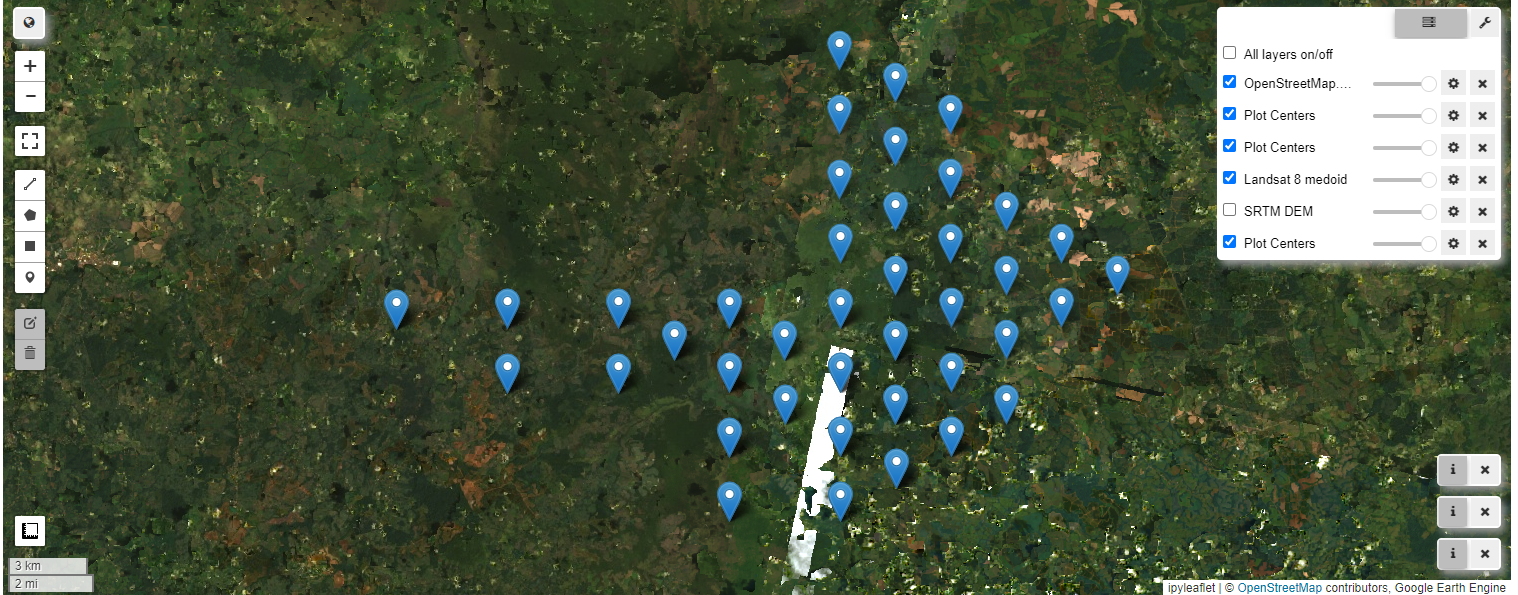

## Setup

In [ ]:
#import packages
import geopandas as gpd, pandas as pd, os, numpy as np
import ee, geemap

## Authenticate and Initialize the project

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jshogland') #you will want to select your personal cloud project

# Section 1: Reading in the data and visualizing with geopandas and folium
## Read the Classification_Plots.zip shape file into a geodataframe

In [ ]:
gdf=gpd.read_file('../Costa_Rica_Data/Classification_Plots.zip') ##../ in the relative path moves out of the templates directory into the CostaRica-Notebook directory

## Display the spatial orientation of the first 2 plots and subplots using geopandas and folium
### Red points are the subplots and the blue point is the center plot

In [ ]:
import folium
cplot_index=np.arange(4,gdf.shape[0],9) # select the plot center using row indecies (center plot starts at 4 and then can be selected based on every ninth record)
plt_center=gdf.iloc[cplot_index] #select all plots from the plot subplots gdf

#display the results using geopandas explore function (uses folium). Note we have not used geemap yet.
m=gdf.iloc[:18].explore(color='red',name='subplots') # pull out the first two plots and subplots (9*2=18)
m=plt_center.explore(m=m,name='Plot center')
folium.LayerControl().add_to(m)
m

## Exercise 1: Interact with the map and update the code above to answer the questions below
- Toggle the plot center layer on and off to verify that the blue point is the center point of the subplots
- Why are there additional blue dots in the field of view? What happens if you zoom out (click the minus button)
- Change the code to view the first 4 subplots (hint 9*4=36)
- Why are the red subplots spread out in a seemingly erratic manner?

# Section 2: Working with Google Earth Engine and Geemap
## Create definitions for the median and medoid procedures

In [ ]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    #Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, overwrite=True).addBands(thermalBands, overwrite=True).updateMask(qaMask).updateMask(saturationMask)

def median_mosaic(image,fltr=None,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    return inCollection.median()

def _medoid(col):
    median = ee.ImageCollection(col).median()
    diff=ee.Image(col).subtract(median).pow(ee.Image.constant(2))
    return diff.reduce('sum').addBands(col)


def medoid_mosaic(image, fltr,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    medoid = inCollection.map(_medoid)
    medoid = ee.ImageCollection(medoid).reduce(ee.Reducer.min(7)).select([1,2,3,4,5,6], refl_bands)
    return medoid



## Set various variable and create the medoid surface on ee

In [ ]:
#make lists fo band names for selections
lc8_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']#landsat band names
tgt_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP', 'QA_PIXEL']#common band names
refl_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']#bands we care about

#specify start and end dates for the image filter
startDate = '2021-01-01'
endDate = '2024-07-01'

#Specify julian dates for filter. Here we want to select sunny months
julianStart1 = 350# Starting Julian Date (for landsat median cloud free )
julianEnd1 = 365
julianStart2 = 1
julianEnd2 = 150# Ending Julian date (for landsat median cloud free)

#define the study area extent from our convex hull
#geo=geemap.gdf_to_ee(gpd.GeoDataFrame(geometry=chul)) #convert our convex hull into a ee feature class object

#make the ee collection
l8_col=ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

#set various filters
#f_bnds=ee.Filter.bounds(geometry=geo)
f_date=ee.Filter.date(startDate,endDate)
f_cr1=ee.Filter.calendarRange(julianStart1,julianEnd1)
f_cr2=ee.Filter.calendarRange(julianStart2,julianEnd2)
f_or=ee.Filter.Or(f_cr1,f_cr2)
f_and=ee.Filter.And(f_date,f_or)

#use our filter on the landsat collection
l8=l8_col.filter(f_and).map(maskL8sr)
l8r=l8.select(lc8_bands,tgt_bands)

#call the medoid function
medoid = medoid_mosaic(l8r,fltr=f_and,refl_bands=refl_bands)

## Create a generic Map using geemap and then map the first 20 plot locations, DEM, and Medoid surface.

In [ ]:
Map = geemap.Map() #create the map object
Map.set_center(lon=-83.7534,lat=9.7489,zoom=8) #center and zoom in on Costa Rica 
Map #show the map

### Add the fist 20 Plots, Elevation, and Ladsat 8 mediod (color bands) image to the map

In [ ]:
# get the dem from EE
dem = ee.Image("USGS/SRTMGL1_003")

# Set visualization parameters for the map.
vis_params = {
    "min": 0,
    "max": 4000,
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"],
}

#Add Earth Engine Landsat 8 medoid to the map
Map.addLayer(
    medoid, {"bands": ["RED", "GREEN", "BLUE"],
             'min':-0.02,
             'max':0.3
    },
    "Landsat 8 medoid",
)

Map.addLayer(dem, vis_params, "SRTM DEM", True, 1)

#Add plot centers to the map
Map.add_gdf(plt_center.iloc[:40],layer_name='Plot Centers')


## Exercise 2: Interacting with Geemap
- Toggle the off the elevation map
- Do you see anything concerning about the center plot locations?
- What do you think the white strip phenomena is?
- Change the code to the first 40 point records. What happens to the map legend? Why does this behave differently than folium?
- How would you reset the map before adding layers?
- Make a geemap for the Canopy Height data. What do you see?